# Import

In [1]:
import numpy as np

# Define

In [2]:
def guess_square_error(input_answers, input_weights = None):
    rowwise_mean = np.average(input_answers, axis = 0)
    for a in range(input_answers.shape[0]):
        input_answers[a] -= rowwise_mean

    square_ans = input_answers * input_answers
    if input_weights != None:
        for a in range(input_answers.shape[0]):
            square_ans[a] *= input_weights[a]

    return square_ans.sum()

class SingleEntryMatrix():
    def __init__(self, size):
        self.elements = np.zeros(size + size, dtype = bool)
        for i in range(size[0]):
            for j in range(size[1]):
                self.elements[i][j][i][j] = True

class VariableArray():
    def __init__(self, size, mean = 0., std = 1., work_components = 1., is_independent_learning = False):
        self.size = size
        self.values = np.random.normal(mean, std, size)
        self.diff = np.zeros(size)
        self.drop = np.ones(size, dtype = bool)
        if work_components == 1:
            self.work = np.ones(size, dtype = bool)
        else:
            self.work = (np.random.random(size) < work_components)
        
        self.values *= self.work
        
        if is_independent_learning:
            self.eta_m = np.zeros(size)
        else:
            self.eta_m = None

    def move(self, eta = None):
        if eta == None:
            self.values -= self.eta_m * self.diff * self.work
        else:
            self.values -= eta * self.diff * self.work

    def zerodiff(self):
        self.diff *= 0.
        
    def set_drop(self, rate):
        self.drop = (np.random.random(size) < rate)

class Sigmoid():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        output = np.zeros([self.dd])
        for i in range(self.dd):
            output[i] = 1 / (1 + np.exp(-x[i]))
        
        return output
    
    def diff(self, x):
        output = np.zeros([self.cd, self.dd])
        for i in range(len(x)):
            output[i][i] = 1 / (1 + np.exp(x[i]) * (1 + np.exp(-x[i])))
            
        return output
    
class Identity():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.identity(self.dd)

class Layer():
    def __init__(self, layers_from, nodes_n, active_function):
        self.lf = layers_from # list :layers connected before
        self.lt = [] # layers connected after
        self.nodes_n = nodes_n
        self.weights = {}
        self.input_bias = VariableArray([self.nodes_n])
        self.nodes_input = np.zeros([self.nodes_n])
        self.nodes_output = np.zeros([self.nodes_n])
        self.nodes_diff = np.zeros([self.nodes_n, self.nodes_n])
        self.backwards = {}
        self.af = active_function
        self.af.set_dim(self.nodes_n)
            
    def forward(self):
        self.nodes_output = self.af.trans(self.nodes_input)

    def jacobi(self):
        self.nodes_diff = self.af.diff(self.nodes_input)
    
class DogikoNN():
    def __init__(self):
        self.pp_linear = {
            "multi" : None,
            "trans" : None
        } # pre-processing linear translation
        self.flow = []
        self.layers = {}
    
    def set_training_data(self, input_datas, input_answers, input_weights = None):
        # type input_data : numpy array
        # type input_answer : numpy array
        self.t_datas = input_datas
        self.t_answers = input_answers
        self.t_weights = input_weights
        self.data_size = self.t_datas.shape[1:]
        self.answer_size = self.t_answers.shape[1:]
        if self.t_weights == None:
            self.t_square_error = guess_square_error(self.t_answers)
        else:
            self.t_square_error = guess_square_error(self.t_answers, self.t_weights)
        
        if self.t_square_error == 0:
            self.t_square_error = 1
            print ("all training data has same result, can't normalize error")
    
    def set_validating_data(self, input_datas, input_answers, input_weights = None):
        # type input_data : numpy array
        # type input_answer : numpy array
        if input_datas.shape[1:] != self.data_size:
            print ("Size of datas should be the same as training data, must set_training_data before set_validating_data!")

        if input_answers.shape[1:] != self.answer_size:
            print ("Size of answers should be the same as training data, must set_training_data before set_validating_data!")
            
        self.v_datas = input_datas
        self.v_answers = input_answers
        self.v_weights = input_weights
        if self.v_weights == None:
            self.v_square_error = guess_square_error(self.v_answers)
        else:
            self.v_square_error = guess_square_error(self.v_answers, self.v_weights)
        
        if self.v_square_error == 0:
            self.v_square_error = 1
            print ("all validating data has same result, can't normalize error")
        
    def define_normalization(self, normalized_algorithm):
        self.normal_alg = normalized_algorithm
    
    def normalized(self, input_datas):
        output = np.zeros(input_datas.shape)
        for d in range(len(input_datas)):
            output[d] = self.pp_linear["multi"] * (self.t_datas[d] - self.pp_linear["trans"])
        
        return output
    
    def layers_clear(self):
        self.layers = {}
        
    def insert_layer(self, name, layer, is_flow_add = True):
        self.layers[name] = layer
        if is_flow_add:
            self.flow.append(name)
        
    def build(self):
        if self.normal_alg == "normal":
            temp_trans_datas = self.t_datas.T
            self.single_data_size = len(temp_trans_datas)
            temp_square_mean_array = np.zeros([self.single_data_size])
            temp_sd = np.zeros([self.single_data_size])
            self.pp_linear["trans"] = np.zeros([self.single_data_size])
            for j in range(self.single_data_size):
                feature = temp_trans_datas[j]
                self.pp_linear["trans"][j] = feature.mean()
                temp_sd[j] = feature.std()
            
            temp_sd[temp_sd == 0] = 1
            self.pp_linear["multi"] = 1 / temp_sd
            
        else:
            print ("unacceptable normalized_algorithm")
            return ("unacceptable normalized_algorithm")
        
        self.n_t_datas = self.normalized(self.t_datas)
        self.n_v_datas = self.normalized(self.v_datas)
        if len(self.flow) != len(set(self.flow)):
            print ("each element in .flow should be unique (layer name)")
            return ("each element in .flow should be unique (layer name)")
        
        self.single_entry_matrix = {}
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].lt = []
            for lnf in self.layers[ln].lf:
                if lnf == "input source":
                    self.layers[ln].weights[lnf] = VariableArray((self.layers[ln].nodes_n, self.single_data_size,))
                    self.layers[ln].backwards[lnf] = np.zeros([self.single_data_size])
                elif lnf not in self.layers:
                    print ("layer " + lnf + " doesn't exist!")
                else:
                    if self.flow.index(lnf) > l:
                        print ("layer " + lnf + " shoud work before layer " + ln)
                        return ("layer " + lnf + " shoud work before layer " + ln)
                    
                    self.layers[lnf].lt.append(ln)
                    self.layers[ln].weights[lnf] = VariableArray((self.layers[ln].nodes_n, self.layers[lnf].nodes_n))
                    self.layers[ln].backwards[lnf] = np.zeros([self.layers[lnf].nodes_n])
                
                self.single_entry_matrix[self.layers[ln].weights[lnf].size] = SingleEntryMatrix(self.layers[ln].weights[lnf].size)
        
        self.layers[self.flow[-1]].lt.append("output result")
    
    def t_cost_greadient(self, predict, answer):
        return (predict - answer) / self.t_square_error
        
    def forward_propagation(self, input_array):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].nodes_input *= 0.
            for lnf in self.layers[ln].lf:
                if lnf == "input source":
                    self.layers[ln].nodes_input += self.layers[ln].weights[lnf].values.dot(input_array)
                else:
                    self.layers[ln].nodes_input += self.layers[ln].weights[lnf].values.dot(self.layers[ln2].nodes_output)
                    
            self.layers[ln].nodes_input += self.layers[ln].input_bias.values
            self.layers[ln].forward()
            self.layers[ln].jacobi()
            
        return self.layers[self.flow[-1]].nodes_output
    
    def prediction(self, input_data):
        output = np.zeros(input_data.shape[:1] + self.answer_size)
        for d in range(input_data.shape[0]):
            output[d] = self.forward_propagation(input_data[d])
        
        return output
    
    def backward_propagation(self, data, answer, predict, cost_gradient, weight = None):
        temp_array = np.zeros([self.layers[self.flow[-1]].nodes_n])
        if weight == None:
            weight = 1.
        for l in range(len(self.flow) - 1, -1, -1):
            ln = self.flow[l]
            for lnt in self.layers[ln].lt:
                if lnt == "output result":
                    temp_array += cost_gradient(predict, answer)
                else:
                    temp_array += self.layers[lnt].backward[ln]
            
            self.layers[ln].input_bias.diff += weight * temp_array
            temp_array = temp_array.dot(self.layers[ln].nodes_diff)
            for lnf in self.layers[ln].lf:
                for i in range(self.layers[ln].weights[lnf].size[0]):
                    for j in range(self.layers[ln].weights[lnf].size[1]):
                        if self.layers[ln].weights[lnf].work[i][j] and self.layers[ln].weights[lnf].drop[i][j]:
                            if lnf == "input source":
                                self.layers[ln].weights[lnf].diff[i][j] += weight * temp_array.dot(
                                    self.single_entry_matrix[self.layers[ln].weights[lnf].size].elements[i][j].dot(data)
                                )                                
                            else:
                                self.layers[ln].weights[lnf].diff[i][j] += weight * temp_array.dot(
                                    self.single_entry_matrix[self.layers[ln].weights[lnf].size].elements[i][j].dot(self.layers[lnf].nodes_output)
                                )
                        
                self.layers[ln].backwards[lnf] = temp_array.dot(self.layers[ln].weights[lnf].values)
                
    def var_zerodiff(self):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].input_bias.zerodiff()
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].zerodiff()
    
    def var_move(self, eta):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].input_bias.move(eta)
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].move(eta)
                
    def single_batch(self, batch_datas, batch_answers, batch_weights = None, eta = None, g_change = None):
        self.var_zerodiff()
        batch_prediction = self.prediction(batch_datas)
        for d in range(len(batch_datas)):
            if batch_weights == None:
                self.backward_propagation(batch_datas[d], batch_prediction[d], batch_answers[d], self.t_cost_greadient, weight = None)
            else:
                self.backward_propagation(batch_datas[d], batch_prediction[d], batch_answers[d], self.t_cost_greadient, weight = batch_weights[d])
        self.var_move(eta)
            
    def single_epoch(self, batch_size, batchs_n = None, eta = None,  g_change = None, shuffle = False):
        batchs_allow = int(len(self.n_t_datas) / batch_size)
        if batchs_allow == 0:
            print("batch size should smaller than testing data amount")
            return "batch size should smaller than testing data amount"
        
        if batchs_n == None:
            batchs_n = batchs_allow
        
        if shuffle:
            pass
        else:
            for b in range(min(batchs_allow, batchs_n)):
                batch_datas = self.n_t_datas[b * batch_size:(b+1) * batch_size]
                batch_answers = self.t_answers[b * batch_size:(b+1) * batch_size]
                if self.t_weights != None:
                    batch_weights = self.t_weights[b * batch_size:(b+1) * batch_size]
                else:
                    batch_weights = None
                
                self.single_batch(batch_datas, batch_answers, batch_weights = batch_weights, eta = eta, g_change = g_change)
    
    def validating_error(self):
        temp_prediction = self.prediction(self.v_datas)
        temp_diff = temp_prediction - self.v_answers
        if self.v_weights != None:
            for d in range(temp_diff.size[1]):
                temp_diff[d] *= self.v_weights[d]
        
        output = (temp_diff * temp_diff / self.v_square_error).sum()
        return output

# example
Use 1 layer linear model predict sin-wave superposition with some noise

In [9]:
lms_NN = DogikoNN()

pre_d = np.zeros([400])
for i in range(400):
    pre_d[i] = np.sin(np.pi * i /20) + np.sin(np.pi * i /13)

pre_d += (0.4 * np.random.rand(400) - 0.2)

try_data = np.zeros([330, 64])
try_answer = np.zeros([330, 2])
for i in range(320):
    try_data[i] = pre_d[i:i+64]
    try_answer[i] = pre_d[i+64:i+66]

lms_NN.set_training_data(try_data, try_answer)
lms_NN.set_validating_data(try_data, try_answer)

lms_NN.define_normalized("normal")

lms_NN.insert_layer(
    'A',
    Layer(
        layers_from = ["input source"],
        nodes_n = 2,
        active_function = Identity()
    )
)

lms_NN.build()

In [26]:
for t in range(1000):
    lms_NN.single_epoch(110, eta = 0.3)
    print(t + 1, lms_NN.validating_error())

1 0.0186032001274
2 0.0185848960935
3 0.0185666453845
4 0.0185484478314
5 0.0185303032659
6 0.0185122115205
7 0.018494172428
8 0.0184761858217
9 0.0184582515359
10 0.0184403694051
11 0.0184225392645
12 0.0184047609498
13 0.0183870342975
14 0.0183693591443
15 0.0183517353277
16 0.0183341626858
17 0.0183166410572
18 0.0182991702809
19 0.0182817501966
20 0.0182643806447
21 0.0182470614658
22 0.0182297925014
23 0.0182125735932
24 0.0181954045839
25 0.0181782853162
26 0.0181612156338
27 0.0181441953807
28 0.0181272244014
29 0.0181103025412
30 0.0180934296456
31 0.0180766055609
32 0.0180598301337
33 0.0180431032113
34 0.0180264246415
35 0.0180097942725
36 0.0179932119532
37 0.0179766775329
38 0.0179601908614
39 0.0179437517891
40 0.0179273601668
41 0.017911015846
42 0.0178947186785
43 0.0178784685167
44 0.0178622652135
45 0.0178461086223
46 0.0178299985971
47 0.0178139349922
48 0.0177979176625
49 0.0177819464635
50 0.017766021251
51 0.0177501418813
52 0.0177343082115
53 0.0177185200988
54 0.

In [11]:
import matplotlib.pyplot as plt

In [24]:
predict_data = np.zeros([167,64])
for i in range(167):
    predict_data[i] = pre_d[2*i:2*i + 64]

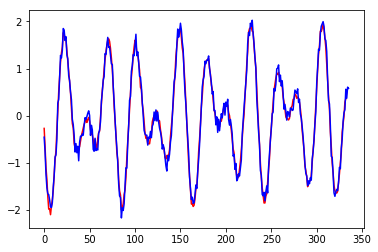

In [27]:
ans = lms_NN.prediction(predict_data)
plt.plot(ans.reshape(334), "-r", pre_d[64:], "-b")
plt.show()

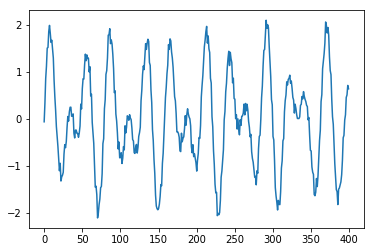

In [8]:
plt.plot(pre_d)
plt.show()

In [7]:
class foo():
    def __init__(self, x):
        self.x = 3 * x

class foooo():
    def __init__(self, y, cla):
        self.f = cla(y)
        